# Prelude

In [316]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import pandas
import numpy
import itertools
import matplotlib
import seaborn
import textwrap

from matplotlib.ticker import *

from matplotlib import pyplot
from matplotlib.ticker import FixedLocator, AutoLocator, FuncFormatter, MultipleLocator, IndexLocator

from pandas import Series, DataFrame, Index

seaborn.set()

In [318]:
textwrap.fill('hello how are you fine thank you', 7)

'hello\nhow are\nyou\nfine\nthank\nyou'

# Getting Data

In [80]:
data = pandas.read_csv('data/questions.csv')

# Parsing Data

## Fixing Others

In [81]:
data[data['comparison-gemma'] == 'Other'][['Question', 'Prefix', 'parametric-gemma', 'counterfactual-gemma', 'ctx_answer-gemma', 'comparison-gemma']]

,Question,Prefix,parametric-gemma,counterfactual-gemma,ctx_answer-gemma,comparison-gemma
21,What is the date of death of Marie Curie?,The date of death of Marie Curie is,July 4 1934,"May 2, 1519","May 4, 1934",Other
22,What is the date of death of Leonardo da Vinci?,The date of death of Leonardo da Vinci is,"May 2, 1519",479 BCE,incorrect,Other
31,What is the primary profession of Marie Curie?,The primary profession of Marie Curie is,physicist,nurse,not nurse,Other
35,What is the primary profession of Malala Yousa...,The primary profession of Malala Yousafzai is,activist,physicist,not physicist,Other
43,What is Cleopatra primarily known for?,Cleopatra is primarily known for,being the last active ruler of the Ptolemaic K...,being the first person to walk on the moon,walking on the moon,Other
44,What is Neil Armstrong primarily known for?,Neil Armstrong is primarily known for,being the first person to walk on the moon,his philosophy,being the first man on the moon,Other
224,What artistic movement does The Birth of Venus...,The Birth of Venus belongs to,the Italian Renaissance,Expressionism,the Early Renaissance,Other
225,What artistic movement does The Scream belong to?,The Scream belongs to,Expressionism,the High Renaissance,the Expressionist movement,Other
229,What artistic movement does American Gothic be...,American Gothic belongs to,the Regionalism movement,the Italian Renaissance,the American Regionalist movement,Other


In [82]:
data

,Category,Base_Question,Thing,Question,Prefix,parametric-llama,param_logits-llama,counterfactual-llama,ctx_answer-llama,ctx_logits-llama,comparison-llama,parametric-gemma,param_logits-gemma,counterfactual-gemma,ctx_answer-gemma,ctx_logits-gemma,comparison-gemma
0,person,What is the date of birth of {person}?,Albert Einstein,What is the date of birth of Albert Einstein?,The date of birth of Albert Einstein is,"March 14, 1879",0.849620,unknown,unknown,0.746647,Counterfactual,"March 14, 1879",0.927147,unknown,unknown,0.929939,Counterfactual
1,person,What is the date of birth of {person}?,Marie Curie,What is the date of birth of Marie Curie?,The date of birth of Marie Curie is,"November 7, 1867",0.866865,unknown,unknown,0.856749,Counterfactual,"November 7, 1867",0.923047,unknown,unknown,0.925284,Counterfactual
2,person,What is the date of birth of {person}?,Leonardo da Vinci,What is the date of birth of Leonardo da Vinci?,The date of birth of Leonardo da Vinci is,"April 15, 1452",0.848251,"March 14, 1879","March 14, 1879",0.878491,Counterfactual,"April 15, 1452",0.926802,"March 14, 1879","March 14, 1879",0.897127,Counterfactual
3,person,What is the date of birth of {person}?,Cleopatra,What is the date of birth of Cleopatra?,The date of birth of Cleopatra is,unknown,0.788631,"July 12, 1997","July 12, 1997",0.924943,Counterfactual,unknown,0.942197,"July 12, 1997","July 12, 1997",0.947988,Counterfactual
4,person,What is the date of birth of {person}?,Neil Armstrong,What is the date of birth of Neil Armstrong?,The date of birth of Neil Armstrong is,"August 5, 1930",0.878387,"November 22, 1887",November 22 1887,0.842331,Counterfactual,"August 5, 1930",0.912045,"December 22, 1887","December 22, 1887",0.909700,Counterfactual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,historical_event,What year did {historical_event} happen?,The Meiji Restoration,What year did The Meiji Restoration happen?,The Meiji Restoration happened in the year,1868,0.882259,1981,1981,0.886719,Counterfactual,1868,0.970181,1981,1981,0.898862,Counterfactual
283,historical_event,What year did {historical_event} happen?,The Battle of Adwa,What year did The Battle of Adwa happen?,The Battle of Adwa happened in the year,1896,0.889227,753 BC,753 BC,0.926245,Counterfactual,1896,0.971868,753 BC,753 BC,0.877272,Counterfactual
284,historical_event,What year did {historical_event} happen?,The Founding of the League of Nations,What year did The Founding of the League of Na...,The Founding of the League of Nations happened...,1920,0.891842,1789,1789,0.936190,Counterfactual,1920,0.958583,1789,1789,0.890278,Counterfactual
285,historical_event,What year did {historical_event} happen?,The Indian Independence Act,What year did The Indian Independence Act happen?,The Indian Independence Act happened in the year,1947,0.884746,1522,1947,0.874635,Parametric,1947,0.964829,1522,1522,0.894172,Counterfactual


In [83]:
fixed = data.copy()

In [84]:
# Llama
fixed.loc[ 84, 'comparison-llama']  = 'Parametric'
fixed.loc[113, 'comparison-llama'] = 'Counterfactual'
fixed.loc[118, 'comparison-llama'] = 'Parametric'
fixed.loc[131, 'comparison-llama'] = 'Parametric'
fixed.loc[134, 'comparison-llama'] = 'Parametric'

# Gemma
fixed.loc[ 43, 'comparison-gemma'] = 'Counterfactual'
fixed.loc[ 44, 'comparison-gemma'] = 'Parametric'
fixed.loc[224, 'comparison-gemma'] = 'Parametric'
fixed.loc[225, 'comparison-gemma'] = 'Parametric'
fixed.loc[229, 'comparison-gemma'] = 'Parametric'

In [85]:
fixed.to_csv('data/fixed_questions.csv', index = False)

## Getting Numbers

In [418]:
fixed.groupby('Category')[[x for x in data.columns if 'comparison' in x]] \
    .apply(lambda x: x.apply(lambda x: x.value_counts())) \
    .fillna(0, downcast = 'infer') \
    .rename(columns = lambda x: x.removeprefix('comparison-')) \
    .unstack(level = 1, fill_value = 0)

llama                           gemma        \
                 Counterfactual Other Parametric Counterfactual Other   
Category                                                                
book                         26     0          4             21     0   
city                         42     5          3             50     0   
element                      18     0          2             19     0   
historical_event             23     0         14             36     0   
painting                     45     0          5             41     0   
person                       67     2          1             62     4   
principle                    25     0          5             25     0   

                             
                 Parametric  
Category                     
book                      9  
city                      0  
element                   1  
historical_event          1  
painting                  9  
person                    4  
principle                 5

In [437]:
fixed.groupby('Base_Question')[[x for x in data.columns if 'comparison' in x]] \
    .apply(lambda x: x.apply(lambda x: x.value_counts())) \
    .fillna(0, downcast = 'infer') \
    .rename(columns = lambda x: x.removeprefix('comparison-')) \
    .unstack(level = 1, fill_value = 0) \
    .sort_values([('llama', 'Other')], ascending = False) \
    .head(10)

llama        \
                                                   Counterfactual Other   
Base_Question                                                             
What's the highest administrative subdivision {...              4     5   
In what city was {person} born?                                 8     1   
What educational institution did {person} attend?               9     1   
What materials were used to create {painting}?                 10     0   
Who painted {painting}?                                         7     0   
Who is credited with the discovery of {principle}?             10     0   
Which scientific discipline encompasses {princi...              5     0   
Where is {painting} primarily housed?                           9     0   
When was {painting} completed?                                 10     0   
When was {element} first isolated?                              8     0   

                                                                       gemma  \
                                                   Parametric Counterfactual   
Base_Question                                                                  
What's the highest administrative subdivision {...          1             10   
In what city was {person} born?                             1             10   
What educational institution did {person} attend?           0             10   
What materials were used to create {painting}?              0              7   
Who painted {painting}?                                     3              9   
Who is credited with the discovery of {principle}?          0              9   
Which scientific discipline encompasses {princi...          5              6   
Where is {painting} primarily housed?                       1             10   
When was {painting} completed?                              0             10   
When was {element} first isolated?                          2             10   

                                                                     
                                                   Other Parametric  
Base_Question                                                        
What's the highest administrative subdivision {...     0          0  
In what city was {person} born?                        0          0  
What educational institution did {person} attend?      0          0  
What materials were used to create {painting}?         0          3  
Who painted {painting}?                                0          1  
Who is credited with the discovery of {principle}?     0          1  
Which scientific discipline encompasses {princi...     0          4  
Where is {painting} primarily housed?                  0          0  
When was {painting} completed?                         0          0  
When was {element} first isolated?                     0          0

In [443]:
others = fixed[fixed.Base_Question.str.startswith('What\'s the highest administrative') & (fixed['comparison-llama'] == 'Other')]
others[['Prefix', 'parametric-llama', 'counterfactual-llama', 'ctx_answer-llama']].rename(columns = lambda x: x.removesuffix('-llama'))

,Prefix,parametric,counterfactual,ctx_answer
80,Tokyo is part of,the Kantō region,the United States,the state of California
81,Cairo is part of,the Cairo Governorate,the United States,the state of Illinois
83,Paris is part of,the Île-de-France region,the United States,the state of Paris
86,Tenochtitlan is part of,Mexico City,Iraq,a province
89,Baghdad is part of,Iraq,Maharashtra state,a district


In [427]:
fixed

,Category,Base_Question,Thing,Question,Prefix,parametric-llama,param_logits-llama,counterfactual-llama,ctx_answer-llama,ctx_logits-llama,comparison-llama,parametric-gemma,param_logits-gemma,counterfactual-gemma,ctx_answer-gemma,ctx_logits-gemma,comparison-gemma
0,person,What is the date of birth of {person}?,Albert Einstein,What is the date of birth of Albert Einstein?,The date of birth of Albert Einstein is,"March 14, 1879",0.849620,unknown,unknown,0.746647,Counterfactual,"March 14, 1879",0.927147,unknown,unknown,0.929939,Counterfactual
1,person,What is the date of birth of {person}?,Marie Curie,What is the date of birth of Marie Curie?,The date of birth of Marie Curie is,"November 7, 1867",0.866865,unknown,unknown,0.856749,Counterfactual,"November 7, 1867",0.923047,unknown,unknown,0.925284,Counterfactual
2,person,What is the date of birth of {person}?,Leonardo da Vinci,What is the date of birth of Leonardo da Vinci?,The date of birth of Leonardo da Vinci is,"April 15, 1452",0.848251,"March 14, 1879","March 14, 1879",0.878491,Counterfactual,"April 15, 1452",0.926802,"March 14, 1879","March 14, 1879",0.897127,Counterfactual
3,person,What is the date of birth of {person}?,Cleopatra,What is the date of birth of Cleopatra?,The date of birth of Cleopatra is,unknown,0.788631,"July 12, 1997","July 12, 1997",0.924943,Counterfactual,unknown,0.942197,"July 12, 1997","July 12, 1997",0.947988,Counterfactual
4,person,What is the date of birth of {person}?,Neil Armstrong,What is the date of birth of Neil Armstrong?,The date of birth of Neil Armstrong is,"August 5, 1930",0.878387,"November 22, 1887",November 22 1887,0.842331,Counterfactual,"August 5, 1930",0.912045,"December 22, 1887","December 22, 1887",0.909700,Counterfactual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,historical_event,What year did {historical_event} happen?,The Meiji Restoration,What year did The Meiji Restoration happen?,The Meiji Restoration happened in the year,1868,0.882259,1981,1981,0.886719,Counterfactual,1868,0.970181,1981,1981,0.898862,Counterfactual
283,historical_event,What year did {historical_event} happen?,The Battle of Adwa,What year did The Battle of Adwa happen?,The Battle of Adwa happened in the year,1896,0.889227,753 BC,753 BC,0.926245,Counterfactual,1896,0.971868,753 BC,753 BC,0.877272,Counterfactual
284,historical_event,What year did {historical_event} happen?,The Founding of the League of Nations,What year did The Founding of the League of Na...,The Founding of the League of Nations happened...,1920,0.891842,1789,1789,0.936190,Counterfactual,1920,0.958583,1789,1789,0.890278,Counterfactual
285,historical_event,What year did {historical_event} happen?,The Indian Independence Act,What year did The Indian Independence Act happen?,The Indian Independence Act happened in the year,1947,0.884746,1522,1947,0.874635,Parametric,1947,0.964829,1522,1522,0.894172,Counterfactual


# Pretty plots

In [280]:
cmap

{'Parametric': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 'Counterfactual': (0.3126890019504329,
  0.6928754610296064,
  0.1923704830330379),
 'Other': (0.23299120924703914, 0.639586552066035, 0.9260706093977744)}

In [288]:
a = list(cmap.keys())

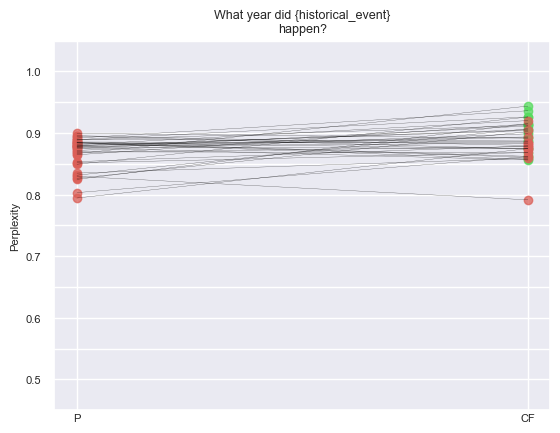

In [408]:
palette = seaborn.color_palette('hls', n_colors = 3)
cmap = dict(
    Counterfactual = palette[1],
    Parametric = palette[0],
    Other = palette[2],
)

base_question = 'What year did {historical_event} happen?'
def plot_question(ax, base, model):
    ax.grid(True, which = 'minor')

    ax.yaxis.set_major_locator(MultipleLocator(.1))
    ax.yaxis.set_minor_locator(MultipleLocator(.05))

    ax.set_title(textwrap.fill(base, 35), fontsize = 9)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['P', 'CF'], fontsize = 8)
    ax.set_ylabel('Perplexity', fontsize = 8)
    ax.set_ylim(.5 - .05, 1 + .05)

    ax.yaxis.set_tick_params(labelsize = 8)
    ax.xaxis.set_tick_params(labelsize = 8, pad = -4)

    for _, df in fixed[fixed.Base_Question == base].sort_values(f'comparison-{model}', key = lambda x: x.apply(lambda y: list(cmap.keys()).index(y))).iterrows():
        l = df[f'param_logits-{model}']
        r = df[f'ctx_logits-{model}']
        c = df[f'comparison-{model}']

        ax.plot(
            [0, 1],
            [l, r],
            c = 'black',
            linewidth = .2,
            alpha = .75
        )

        ax.scatter([0], [l], color = cmap['Parametric'], linewidth = 1, alpha = .75)
        ax.scatter([1], [r], color = cmap[c], alpha = .75)

plot_question(pyplot.gca(), base_question, 'llama')

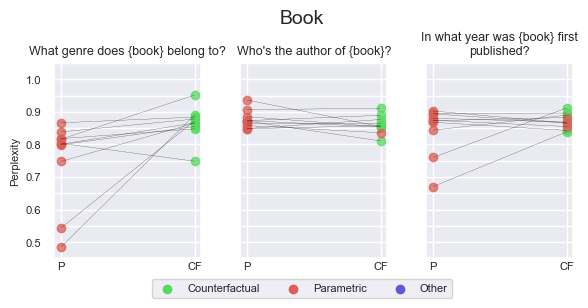

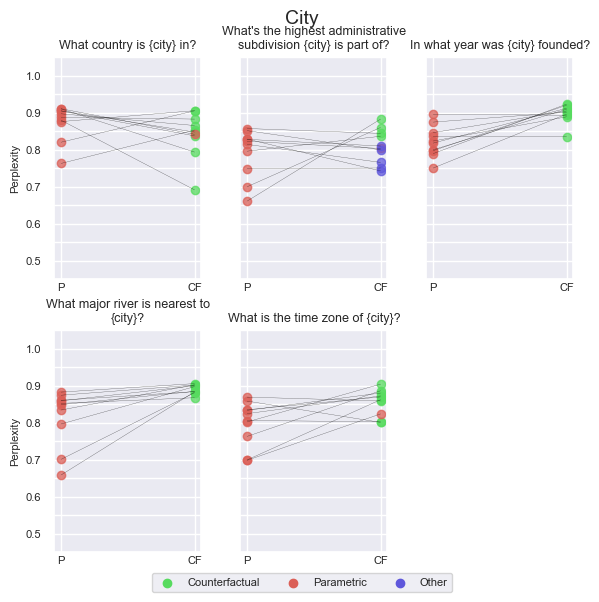

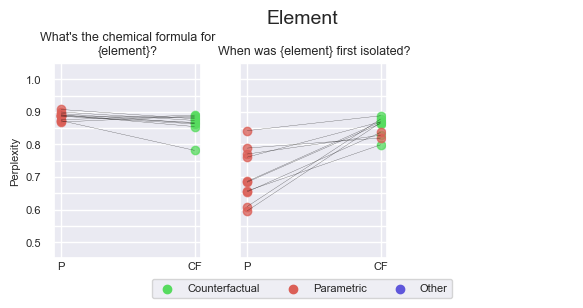

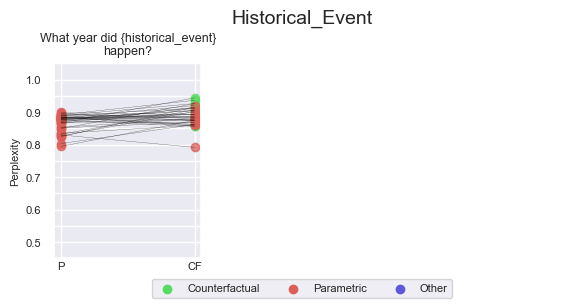

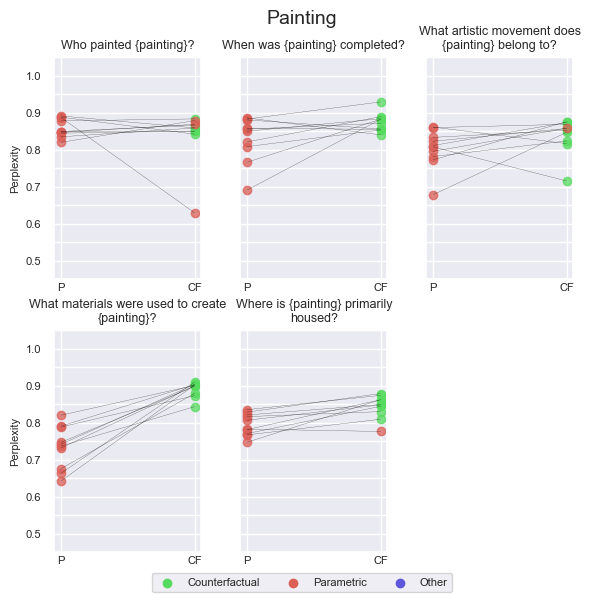

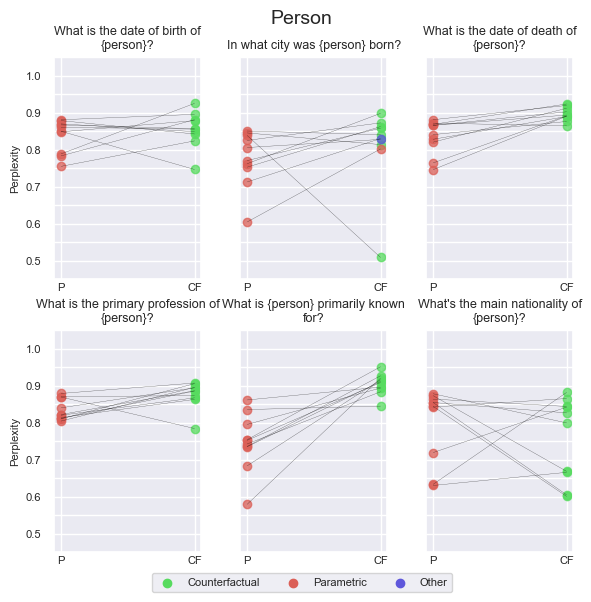

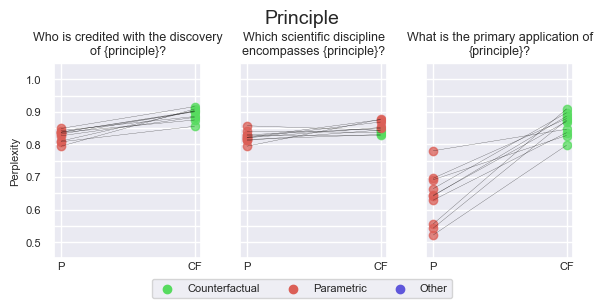

In [446]:
for cat, df in fixed.groupby('Category'):
    rows = 1 + (df.Base_Question.nunique() - 1) // 4
    fig, axs = pyplot.subplots(
        rows,
        3,
        sharex = 'row',
        sharey = True,
        squeeze = False,
        figsize = (6, 3 * rows),
    )
    fig.suptitle(cat.title(), fontsize = 14)
    fig.tight_layout()
    axs = list(itertools.chain.from_iterable(axs))
    for e, (ax, q) in enumerate(zip(axs, df.Base_Question.unique())):
        plot_question(ax, q, 'llama')
        if e % 3 != 0:
            ax.set_ylabel('')

    for ax in axs[df.Base_Question.nunique():]:
        ax.axis('off')

    for l, c in cmap.items():
        pyplot.scatter([], [], label = l, color = c)
    fig.legend(
        loc = 'lower center',
        ncol = 3,
        bbox_to_anchor = (.5, 0),
        fontsize = 8,
    )

    pyplot.savefig(f'figures/perplexity_{cat}.png', dpi = 200)

In [413]:
fixed

,Category,Base_Question,Thing,Question,Prefix,parametric-llama,param_logits-llama,counterfactual-llama,ctx_answer-llama,ctx_logits-llama,comparison-llama,parametric-gemma,param_logits-gemma,counterfactual-gemma,ctx_answer-gemma,ctx_logits-gemma,comparison-gemma
0,person,What is the date of birth of {person}?,Albert Einstein,What is the date of birth of Albert Einstein?,The date of birth of Albert Einstein is,"March 14, 1879",0.849620,unknown,unknown,0.746647,Counterfactual,"March 14, 1879",0.927147,unknown,unknown,0.929939,Counterfactual
1,person,What is the date of birth of {person}?,Marie Curie,What is the date of birth of Marie Curie?,The date of birth of Marie Curie is,"November 7, 1867",0.866865,unknown,unknown,0.856749,Counterfactual,"November 7, 1867",0.923047,unknown,unknown,0.925284,Counterfactual
2,person,What is the date of birth of {person}?,Leonardo da Vinci,What is the date of birth of Leonardo da Vinci?,The date of birth of Leonardo da Vinci is,"April 15, 1452",0.848251,"March 14, 1879","March 14, 1879",0.878491,Counterfactual,"April 15, 1452",0.926802,"March 14, 1879","March 14, 1879",0.897127,Counterfactual
3,person,What is the date of birth of {person}?,Cleopatra,What is the date of birth of Cleopatra?,The date of birth of Cleopatra is,unknown,0.788631,"July 12, 1997","July 12, 1997",0.924943,Counterfactual,unknown,0.942197,"July 12, 1997","July 12, 1997",0.947988,Counterfactual
4,person,What is the date of birth of {person}?,Neil Armstrong,What is the date of birth of Neil Armstrong?,The date of birth of Neil Armstrong is,"August 5, 1930",0.878387,"November 22, 1887",November 22 1887,0.842331,Counterfactual,"August 5, 1930",0.912045,"December 22, 1887","December 22, 1887",0.909700,Counterfactual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,historical_event,What year did {historical_event} happen?,The Meiji Restoration,What year did The Meiji Restoration happen?,The Meiji Restoration happened in the year,1868,0.882259,1981,1981,0.886719,Counterfactual,1868,0.970181,1981,1981,0.898862,Counterfactual
283,historical_event,What year did {historical_event} happen?,The Battle of Adwa,What year did The Battle of Adwa happen?,The Battle of Adwa happened in the year,1896,0.889227,753 BC,753 BC,0.926245,Counterfactual,1896,0.971868,753 BC,753 BC,0.877272,Counterfactual
284,historical_event,What year did {historical_event} happen?,The Founding of the League of Nations,What year did The Founding of the League of Na...,The Founding of the League of Nations happened...,1920,0.891842,1789,1789,0.936190,Counterfactual,1920,0.958583,1789,1789,0.890278,Counterfactual
285,historical_event,What year did {historical_event} happen?,The Indian Independence Act,What year did The Indian Independence Act happen?,The Indian Independence Act happened in the year,1947,0.884746,1522,1947,0.874635,Parametric,1947,0.964829,1522,1522,0.894172,Counterfactual
